# Benasque Spring School on Near-Term Quantum Computing
## Quantum Circuit simulation with Tensor Networks

Let's start with creating a simple quantum circuit:

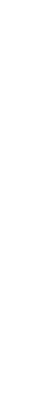

In [1]:
using Quac

n_qubits = 8
circ = Circuit(n_qubits)

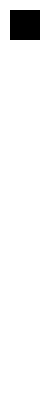

In [2]:
push!(circ, H(1))
circ

Now let's create a simple quantum circuits with `10` qubits and `4` layers of random gates.

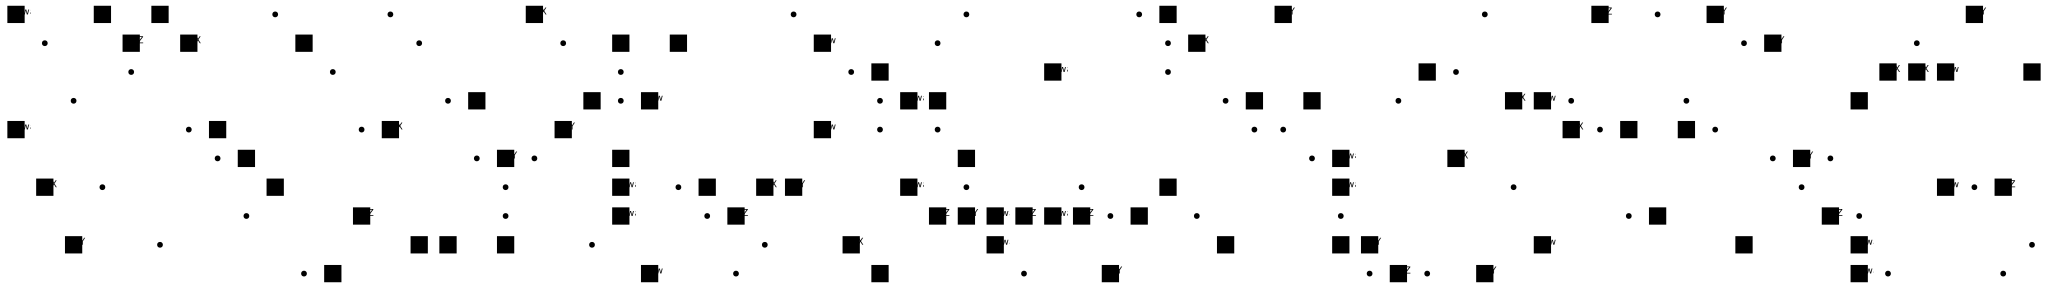

In [3]:
using Random

n = 10
depth = 8

# Define the quantum circuit
circ = Circuit(n)
gates = [Swap, CX, CY, CZ, CRx, CRy, CRz]

Random.seed!(1)

# We want to apply some entangling gates
for _ in 1:depth
    for i in 1:n
        gate = rand(gates)
        j = rand(setdiff(1:n, i))
        push!(circ, gate(i, j))
    end
end

circ

### Exact simulation

Now that we have created a circuit, let's convert it to a tensor network with `Tenet`

In [4]:
using Qrochet

qtn = Quantum(circ)

Quantum (inputs=10, outputs=10)

In [5]:
using Tenet

tn = TensorNetwork(qtn)

TensorNetwork (#tensors=80, #inds=170)

We can use `CairoMakie` to visualize the tensor network:

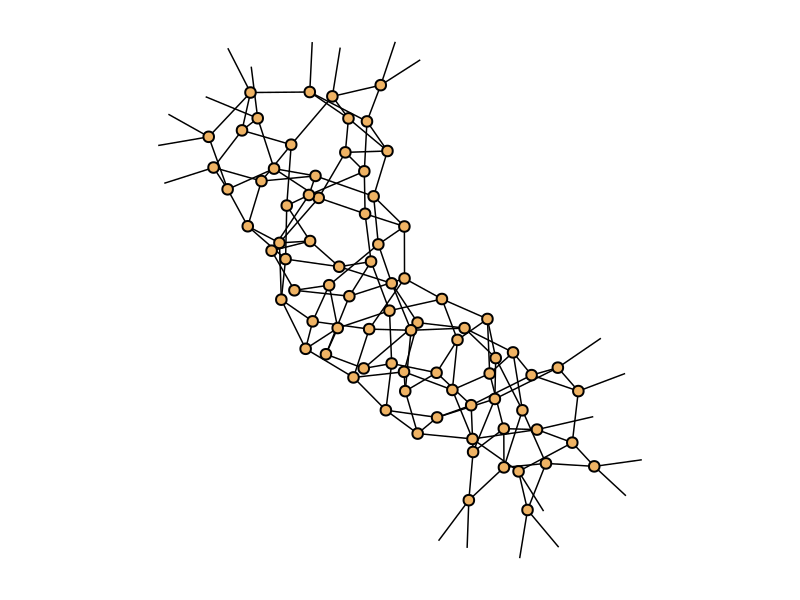

In [6]:
using CairoMakie
using GraphMakie
using NetworkLayout

plot(tn, layout=Stress())

We get a `TensorNetwork` object that contains the tensor network representation of the circuit. It has $2N$ open indices, where $N$ is the number of qubits in the circuit, since we need to connect the input and output  qubits of the circuit to the tensor network. We will now contract the tensor network with the initial and final states to get the expectation value of the circuit.

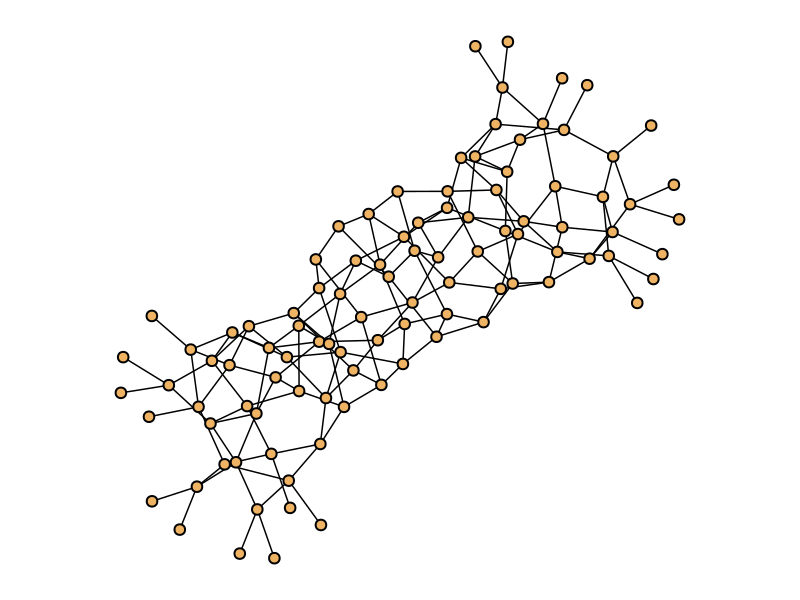

In [7]:
ψᵢₙ = Product(fill([1, 0], n))
ψₒᵤₜ = Product(fill([1, 0], n))

Qrochet.@reindex! inputs(qtn) => outputs(ψᵢₙ)
Qrochet.@reindex! outputs(qtn) => outputs(ψₒᵤₜ)

tn = merge(TensorNetwork(ψᵢₙ), TensorNetwork(qtn), TensorNetwork(ψₒᵤₜ))

plot(tn, layout=Stress())

We can use `EinExprs.jl` to see the contraction path of the tensor network:

In [8]:
using EinExprs

path = einexpr(tn, optimizer=Greedy())
@show total_flops = mapreduce(flops, +, Branches(path))
@show max_dims = maximum(ndims, Branches(path));

total_flops = mapreduce(flops, +, Branches(path)) = 490816
max_dims = maximum(ndims, Branches(path)) = 12


We can also plot the contraction path:

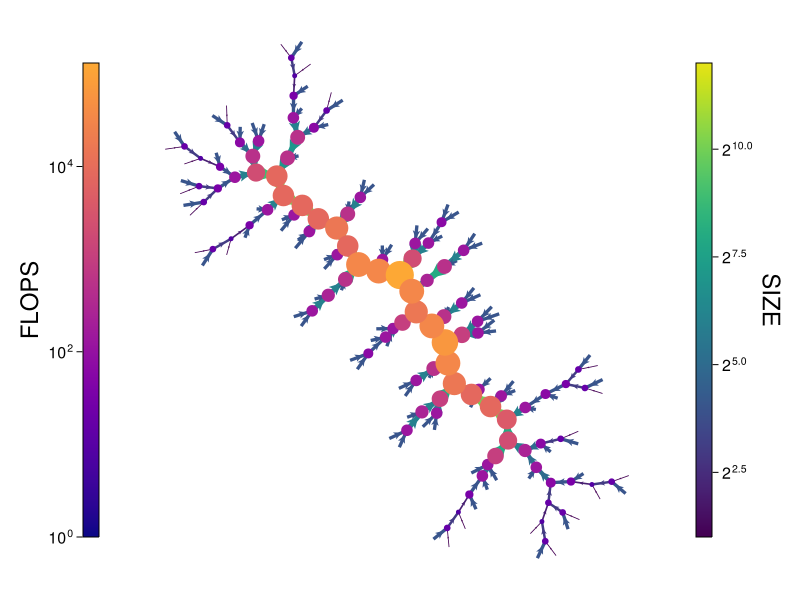

In [9]:
plot(path, layout=Stress())

Okay! Let's contract the circuit:

In [10]:
qtn = Quantum(circ)

ψᵢₙ = Product(fill([1, 0], n))
ψₒᵤₜ = Product(fill([1, 0], n))

Qrochet.@reindex! inputs(qtn) => outputs(ψᵢₙ)
Qrochet.@reindex! outputs(qtn) => outputs(ψₒᵤₜ)

contract(merge(TensorNetwork(ψᵢₙ), TensorNetwork(qtn), TensorNetwork(ψₒᵤₜ)))

0-dimensional Tensor{ComplexF64, 0, Array{ComplexF64, 0}}:
1.0 + 0.0im

### Approximate simulation

Let's create a more complex circuit that is made of two-qubit local gates:

In [11]:
Random.seed!(1)

n = 50
depth = 14

# Define the quantum circuit
gates = [Rxx, Ryy, Rzz]
circ = Circuit(n)
for i in 1:depth
    for j in 1:n-1
        rand_gate = rand(gates)
        push!(circ, rand_gate(j, j+1; θ=rand()*2π))
    end
end

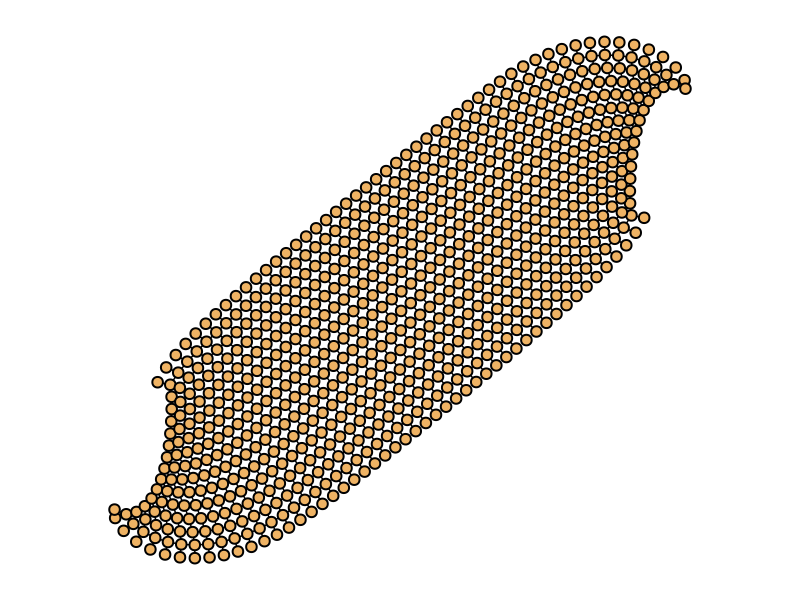

In [12]:
qtn = Quantum(circ)
    
ψᵢₙ = Product(fill([1, 0], n))
ψₒᵤₜ = Product(fill([1, 0], n))

Qrochet.@reindex! inputs(qtn) => outputs(ψᵢₙ)
Qrochet.@reindex! outputs(qtn) => outputs(ψₒᵤₜ)

tn = merge(TensorNetwork(ψᵢₙ), TensorNetwork(qtn), TensorNetwork(ψₒᵤₜ))

plot(tn; layout=Stress())

In [13]:
path = einexpr(tn, optimizer=Greedy())

@show total_flops = mapreduce(flops, +, Branches(path))
@show max_dims = maximum(ndims, Branches(path));

total_flops = mapreduce(flops, +, Branches(path)) = 189931044144
max_dims = maximum(ndims, Branches(path)) = 26


Much larger circuit!! We need an approximation! We will use MPS

In [14]:
ψᵢₙ = Product(fill([1, 0], n))
ψₒᵤₜ = Product(fill([1, 0], n))

qtn = Quantum(circ)

Qrochet.@reindex! inputs(qtn) => outputs(ψᵢₙ)
Qrochet.@reindex! outputs(qtn) => outputs(ψₒᵤₜ)

@time c = contract(merge(TensorNetwork(ψᵢₙ), TensorNetwork(qtn), TensorNetwork(ψₒᵤₜ)))

 60.119682 seconds (16.28 M allocations: 9.226 GiB, 5.39% gc time, 31.74% compilation time)


0-dimensional Tensor{ComplexF64, 0, Array{ComplexF64, 0}}:
-1.4565951521167867e-8 - 1.9906591398540757e-8im

In [15]:
ψᵢₙ = convert(Chain, Product(fill([1, 0], n)))
ψₒᵤₜ = convert(Chain, Product(fill([1, 0], n)))

@time begin
    # Apply gates using `evolve!` function  
    for gate in circ
        evolve!(ψᵢₙ, gate; maxdim=2)
    end

    overlap(ψᵢₙ, ψₒᵤₜ)
end

 21.283481 seconds (23.96 M allocations: 1.623 GiB, 1.44% gc time, 91.68% compilation time)


0-dimensional Tensor{ComplexF64, 0, Array{ComplexF64, 0}}:
-3.143666419874395e-42 + 4.601237689378356e-44im

In [16]:
using LinearAlgebra

@show fidelity = norm(ψᵢₙ);

fidelity = norm(ψᵢₙ) = 3.201348240983653e-10


We can limit the bond dimension of the MPS to the computational complexity of the operation. A limit in the bond dimension can be thought as a limit in the entanglement of the state. The bond dimension is a trade-off between accuracy and computational cost. The larger the bond dimension, the more accurate the approximation, but the more expensive the computation.

Let's use a reduced bond dimension $\chi$ and compare it with the exact result.

In [17]:
# Let's evolve for different bond dimensions χ and compare to the exact result
results = ComplexF32[]
χ_list = [2, 4, 8, 16, 32, 64, 128]
for χ in χ_list
    ψᵢₙ = convert(Chain, Product(fill([1, 0], n)))
    ψₒᵤₜ = convert(Chain, Product(fill([1, 0], n)))

    canonize!(ψᵢₙ)

    for gate in circ
        evolve!(ψᵢₙ, gate; maxdim=χ, iscanonical=true, renormalize=true)
    end

    push!(results, only(overlap(ψᵢₙ, ψₒᵤₜ)))
end

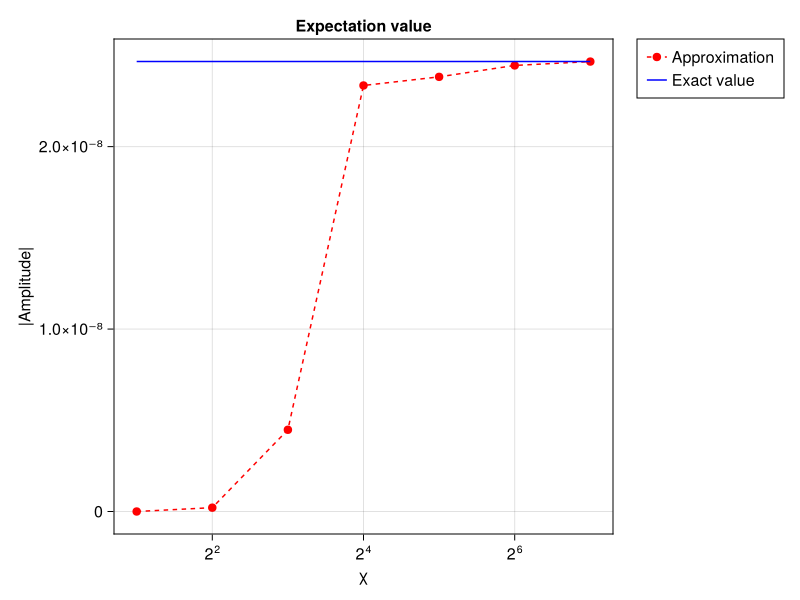

In [18]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="χ", ylabel="|Amplitude|", title="Expectation value", xscale=log2)

scatterlines!(ax, Float32.(χ_list), abs.(results), color=:red, linestyle=:dash, marker=:circle, label="Approximation")
lines!(ax, Float32.(χ_list), abs(only(c))*ones(length(χ_list)), color=:blue, linestyle=:solid, label="Exact value")

# Adjust the legend manually
legend = Legend(fig[1, 2], ax, valign=:top)
fig[1, 2] = legend

fig # Display the figure

### Time Evolution of a Matrix Product State

We will use the `Time Evolving Block Decimation (TEBD)` algorithm to simulate the time evolution of a Matrix Product State (MPS) circuit.

##### Transverse-field Ising Model

The Hamiltonian of transverse field Ising model is given by:
$H = -\sum_{\braket{i,j}} \sigma_{X}^{(i)} \sigma_{X}^{(j)} + \lambda \sum_i \sigma_Z^{(i)}$

We will simulate the time evolution of a quantum state under this Hamiltonian, and we will measure some `observables` of the system.

In the `TEBD` algorithm we will use the Suzuki-Trotter decomposition to the first order, which approximates $e^{-iHt}$ as $e^{-iH_1 \Delta t} e^{-iH_2 \Delta t} ... e^{-iH_n \Delta t}$, where $H = H_1 + H_2 + ... + H_n$, where $\Delta t$ is the time step.

In [20]:
observables = Dense.([Z(5)])

n = 10
δₜ = 0.1
timesteps = 100

100

We define two gates that will be used. The `trotter_XX` gate is a Trotterized version of the XX gate, and the `trotter_Z` gate is a Trotterized version of the Z gate.

In [21]:
function trotter_XX(i,j; δₜ=δₜ)
    mat = kron(Matrix(X()), Matrix(X()))
    mat = cis(δₜ * mat)
    mat = reshape(mat,2,2,2,2)
    Dense(Qrochet.Operator(), mat; sites=Site[Site(i), Site(j), Site(i, dual=true), Site(j, dual=true)])
end

function trotter_Z(i; λ, δₜ=δt)
    mat = Matrix(Z())
    mat = cis(- λ * δₜ * mat)

    Dense(Qrochet.Operator(), mat; sites=Site[Site(i), Site(i, dual=true)])
end

trotter_Z (generic function with 1 method)

We start the quench from a product state where all qubits are in the $|+\rangle$ state.

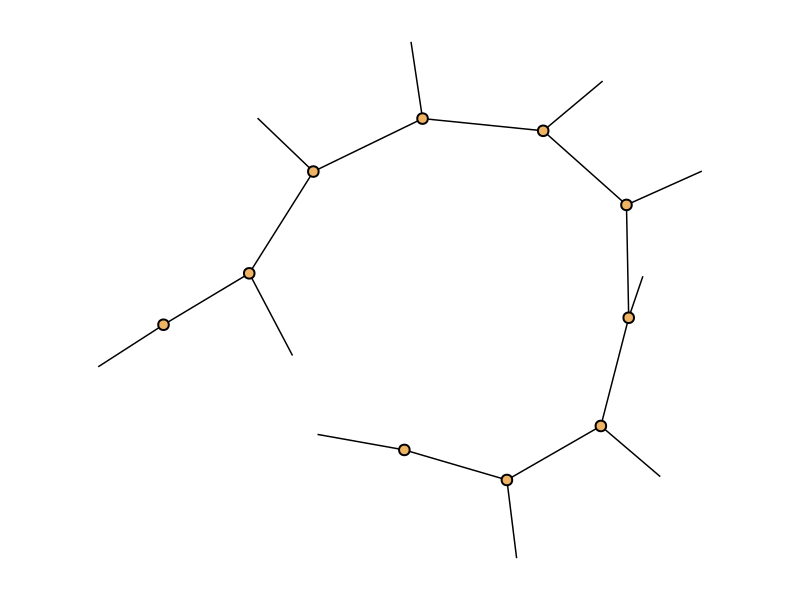

In [22]:
ket₊ = 1/√2 * [1, 1]
ψ = Product(fill(ket₊, n))
ψ = convert(Chain, ψ)

plot(TensorNetwork(ψ))

We can find the energy of the system $|\psi\rangle=| + + \dots + \rangle$ by measuring the expectation value of the Hamiltonian $\langle \psi | H | \psi \rangle$.   

In [26]:
using LinearAlgebra

λ = 0.3

ket₊ = 1/√2 * [1, 1]
ψ = Product(fill(ket₊, n))
ψ = convert(Chain, ψ)

function energy_Ising(ψ, λ)
    id = Matrix(1.0I, 2, 2)
    H = -1 * kron(Matrix(X()), Matrix(X())) + λ * (kron(Matrix(Z()), id) + kron(id, Matrix(Z())))
    H = reshape(H,2,2,2,2)

    e_i = []
    for i in 1:n-1
        H_gate = Dense(Qrochet.Operator(), H; sites=Site[Site(i), Site(i+1), Site(i, dual=true), Site(i+1, dual=true)])
        push!(e_i, only(expect(ψ, [H_gate])))
    end
    return e_i
end

energy_Ising(ψ, λ)

9-element Vector{Any}:
 -0.9999999999999979 + 0.0im
 -0.9999999999999981 + 0.0im
 -0.9999999999999981 + 0.0im
 -0.9999999999999981 + 0.0im
 -0.9999999999999981 + 0.0im
 -0.9999999999999981 + 0.0im
 -0.9999999999999981 + 0.0im
 -0.9999999999999981 + 0.0im
 -0.9999999999999979 + 0.0im

In [49]:
function truncate!(qtn::Chain, bond; threshold::Real = nothing, maxdim::Union{Nothing,Int} = nothing)
    # TODO replace for select(:between)
    vind = rightindex(qtn, bond[1])
    if vind != leftindex(qtn, bond[2])
        throw(ArgumentError("Invalid bond $bond"))
    end

    if vind ∉ inds(TensorNetwork(qtn), :hyper)
        throw(MissingSchmidtCoefficientsException(bond))
    end

    tensor = TensorNetwork(qtn)[vind]
    spectrum = parent(tensor)

    extent = if isnothing(maxdim)
        1:size(TensorNetwork(qtn), vind)
    else
        1:min(size(TensorNetwork(qtn), vind), maxdim)
    end |> collect

    # remove 0s from spectrum
    filter!(extent) do i
        abs(spectrum[i]) > threshold
    end

    slice!(TensorNetwork(qtn), vind, extent)

    return qtn
end

truncate! (generic function with 1 method)

Now we can start the time evolution:

In [50]:
ket₊ = 1/√2 * [1, 1]
ψ = Product(fill(ket₊, n))
ψ = convert(Chain, ψ)

# Time evolution:
expected_vals = Float64[]
@time for it in 1:timesteps
    # First apply the gates on even qubits
    for (i,j) in Iterators.filter(==(2) ∘ length, Iterators.partition(1:n,2))
        evolve!(ψ, trotter_XX(i,j; δₜ))
    end

    # Then apply the gates on odd qubits
    for (i,j) in Iterators.filter(==(2) ∘ length, Iterators.partition(2:n,2))
        evolve!(ψ, trotter_XX(i,j; δₜ))
    end

    # Finally apply the one-qubit gates
    for i in 1:n
        evolve!(ψ, trotter_Z(i; λ=0.3, δₜ))
    end

    # Compute the expectation value of the observable
    push!(expected_vals, abs(only(expect(ψ, observables))))
end

 25.771261 seconds (8.37 M allocations: 663.040 MiB, 0.53% gc time)


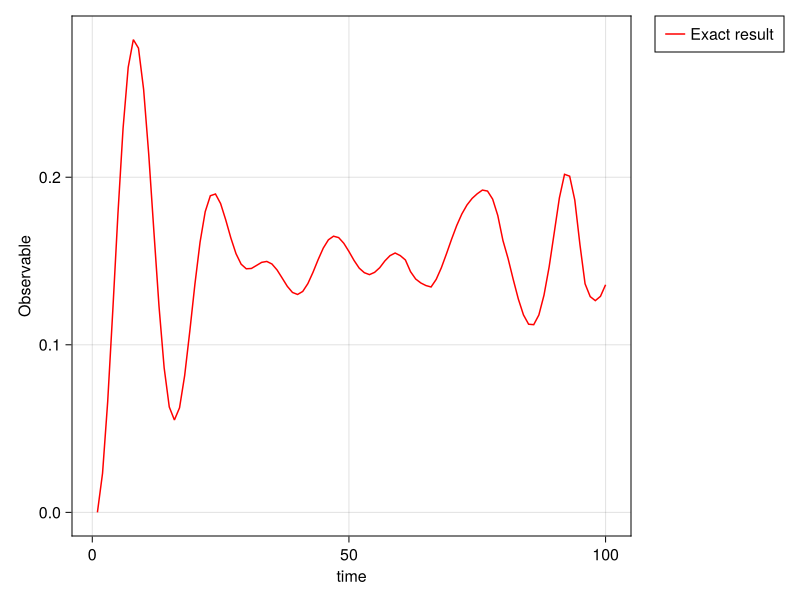

In [52]:
# Plot the expectation value:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="time", ylabel="Observable")
lines!(ax, (1:timesteps) .* δₜ, expected_vals, color=:red, linestyle=:solid, marker=:circle, label="Exact result", fontsize=12)

legend = Legend(fig[1, 2], ax, valign=:top)
fig

But what if we have a large system? We can limit the bond dimension $\chi$!

In [44]:
expectedvals = Dict()

ket₊ = 1/√2 * [1, 1]
ψ_original = convert(Chain, Product(fill(ket₊, n)))

observables = Dense.([Z(5)])

maxdims = [1, 2, 4, 8, 16]

for maxdim in maxdims
    # Reset ψ to its original state for each maxdim iteration
    ψ = deepcopy(ψ_original)
    canonize!(ψ)
    expectedvals_maxdim = Float64[]

    @time for it in 1:timesteps
        for (i,j) in Iterators.filter(==(2) ∘ length, Iterators.partition(1:n,2))
            evolve!(ψ, trotter_XX(i,j; δₜ); maxdim=maxdim, iscanonical=true)
        end
        for (i,j) in Iterators.filter(==(2) ∘ length, Iterators.partition(2:n,2))
            evolve!(ψ, trotter_XX(i,j; δₜ); maxdim=maxdim, iscanonical=true)
        end
        for i in 1:n
            evolve!(ψ, trotter_Z(i; λ=0.3, δₜ); maxdim=maxdim, iscanonical=true)
        end
        push!(expectedvals_maxdim, abs(only(expect(ψ, observables))))
    end

    expectedvals[maxdim] = expectedvals_maxdim
end

 17.992562 seconds (9.75 M allocations: 635.748 MiB, 0.59% gc time, 0.20% compilation time)
 18.395591 seconds (8.34 M allocations: 552.365 MiB, 0.37% gc time)
 19.187975 seconds (8.27 M allocations: 562.391 MiB, 0.35% gc time)
 19.870933 seconds (8.52 M allocations: 618.262 MiB, 0.47% gc time, 0.52% compilation time)
 49.227752 seconds (8.40 M allocations: 702.766 MiB, 0.23% gc time)


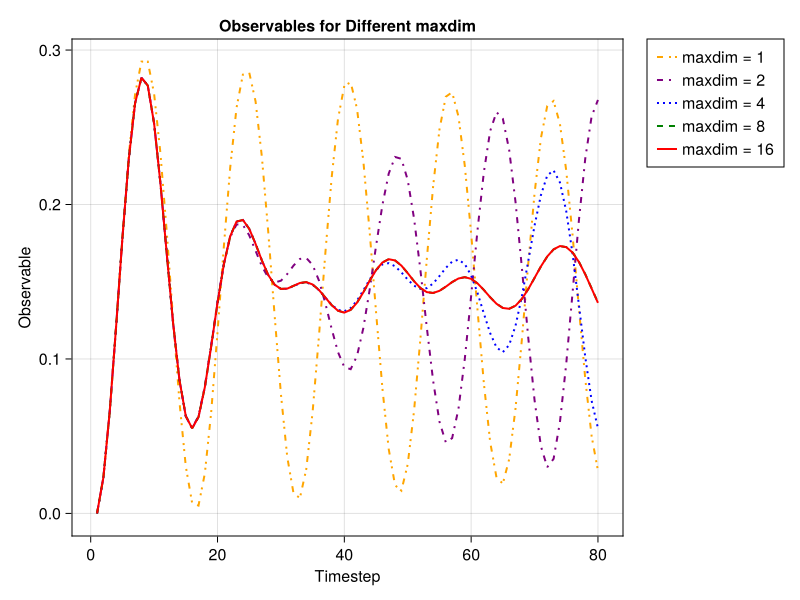

In [45]:
using CairoMakie

# Assuming `expectedvals` and `maxdims` are defined as before

fig = Figure()
ax = Axis(fig[1, 1], xlabel="Timestep", ylabel="Observable", title="Observables for Different maxdim")

# Reverse the order of these arrays to match the reversed maxdims
color_palette = reverse([:red, :green, :blue, :purple, :orange])
line_styles = reverse([(:solid, 2), (:dash, 2), (:dot, 2), (:dashdot, 2), (:dashdotdot, 2)])
markers = reverse([:circle, :square, :diamond, :cross, :star])

# Reverse the order of iteration for maxdims
for (index, maxdim) in enumerate(maxdims)
    # Convert expectedvals[maxdim] to a Float32 array explicitly
    y_values = Float32.(expectedvals[maxdim])
    x_values = Float32.(1:length(y_values)) # Ensure x values are also Float32 for consistency

    lines!(ax, x_values, y_values,
          color=color_palette[index],
          linestyle=line_styles[index][1],
          linewidth=line_styles[index][2],
          marker=markers[index],
          markersize=10,
          label="maxdim = $maxdim")
end

legend = Legend(fig[1, 2], ax, valign=:top)
fig[1, 2] = legend

fig # Display the figure

### Exercise !

Use the `TEBD` algorithm to simulate the time evolution of a Matrix Product State (MPS) under the XXZ Hamiltonian: $H = -\frac{1}{2}\sum^{N}_{i}(\sigma_{i}^{x}\sigma_{i+1}^{x}+\sigma_{i}^{y}\sigma_{i+1}^{y}+\Delta\sigma_{i}^{z}\sigma_{i+1}^{z})$


Measure the magnetization of the system during the quench, which is defined as $M = \frac{1}{N} \sum_{i=1}^{N}\langle\sigma_{i}^{z}\rangle$.
Start with a system where all spins are in the $|\uparrow\rangle$ state. Use the `TEBD` algorithm with a bond dimension $\chi$ to simulate the time evolution of the system.

Tip: Start with a small system (e.g. $N=12$) and a small number of time steps to test your implementation.

- Plot the average magnetization of the system during the quench using `Makie`.
- Do a 2D plot of the magnetization per site $m_{i}$ of the system as a function of time and site. See https://docs.makie.org/stable/reference/plots/heatmap/#example_4a31556a for an example of how to plot a heatmap with `Makie`.
- How does the energy and magnetization of the system change as a function of the bond dimension $\chi$?

In [60]:
δt = 0.1
timesteps = 80
n = 12
Δ = 0

0

In [61]:
function trotter_XXZ(i, j, Δ, δt=δt)
    XX = kron(Matrix(X()), Matrix(X()))
    YY = kron(Matrix(Y()), Matrix(Y()))
    ZZ = kron(Matrix(Z()), Matrix(Z()))
    mat = cis(0.5 * δt * (XX + YY + Δ * ZZ))
    mat = reshape(mat,2,2,2,2)
    Dense(Qrochet.Operator(), mat; sites=Site[Site(i), Site(j), Site(i, dual=true), Site(j, dual=true)])
end

trotter_XXZ (generic function with 2 methods)

In [48]:
ket = [1, 0]
ψ = Product(fill(ket, n))
ψ = convert(Chain, ψ)
canonize!(ψ)

χ = 10

# Time evolution:
expected_vals = ComplexF64[]
magnetization_site = zeros(ComplexF64, n, timesteps)
@time for it in 1:timesteps
    magnetization_val = 0.0
    # First apply the gates on even qubits
    for (i,j) in Iterators.filter(==(2) ∘ length, Iterators.partition(1:n,2))
        evolve!(ψ, trotter_XXZ(i,j,Δ, δt); maxdim=χ, iscanonical=true)
    end

    # Then apply the gates on odd qubits
    for (i,j) in Iterators.filter(==(2) ∘ length, Iterators.partition(2:n,2))
        evolve!(ψ, trotter_XXZ(i,j,Δ, δt); maxdim=χ, iscanonical=true)
    end

    # Compute the expectation value of the observable
    for i in 1:n
        val = only(expect(ψ, Dense.([Z(i)])))
        magnetization_site[i, it] = val
        magnetization_val += val
    end
    push!(expected_vals, magnetization_val/n)
end

 34.003245 seconds (38.41 M allocations: 2.808 GiB, 1.05% gc time, 0.06% compilation time)


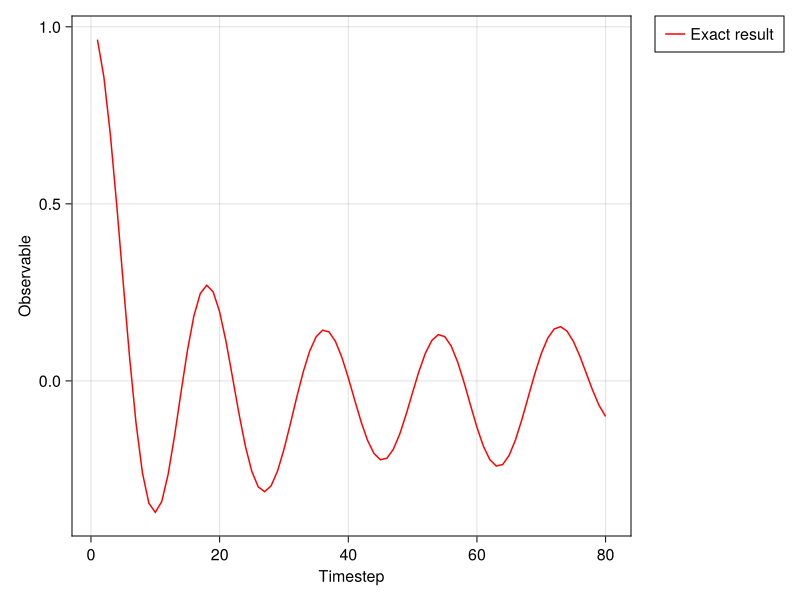

In [49]:
# Plot the expectation value:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="Timestep", ylabel="Observable")
lines!(ax, (1:timesteps), real.(expected_vals), color=:red, linestyle=:solid, marker=:circle, label="Exact result", fontsize=12)

legend = Legend(fig[1, 2], ax, valign=:top)
fig

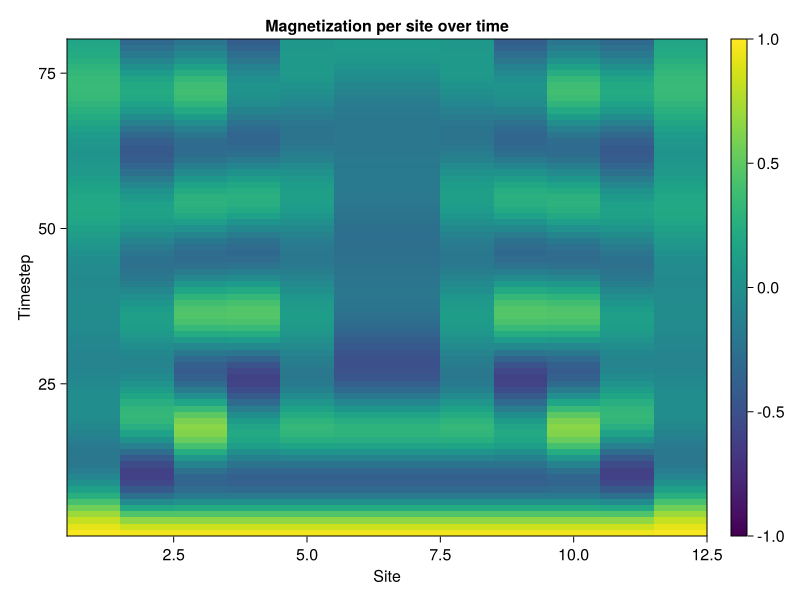

In [50]:
# 2D plot of the magnetization per site over time
fig = Figure()

x_range = 1:n
y_range = 1:timesteps

ax = Axis(fig[1, 1], xlabel="Site", ylabel="Timestep", title="Magnetization per site over time")
hm = heatmap!(ax, x_range, y_range, real.(magnetization_site); colorrange = (-1, 1))

colorbar = Colorbar(fig[1, 2], hm, colorrange = (-1, 1))

fig

In [62]:
# To compute the energy we will have to apply the Hamiltonian to the state

function H_XXZ(i, j, Δ)
    XX = kron(Matrix(X()), Matrix(X()))
    YY = kron(Matrix(Y()), Matrix(Y()))
    ZZ = kron(Matrix(Z()), Matrix(Z()))
    mat = 0.5 * (XX + YY + Δ * ZZ)
    mat = reshape(mat,2,2,2,2)
    Dense(Qrochet.Operator(), mat; sites=Site[Site(i), Site(j), Site(i, dual=true), Site(j, dual=true)])
end

H_XXZ (generic function with 1 method)

In [63]:
χ_list = [2, 4, 8, 16, 32]

magnetization_vals = Dict()
energy_vals = Dict()

for (idx, χ) in enumerate(χ_list)
    @show "Running simulation for χ = $χ"
    ket = [1, 0]
    ψ = Product(fill(ket, n))
    ψ = convert(Chain, ψ)
    canonize!(ψ)

    ψ_initial = deepcopy(ψ)

    # Time evolution:
    m_timestep = 0.0
    m = zeros(ComplexF64, timesteps, n)
    e_timestep = 0.0
    e = ComplexF64[]
    @time for it in 1:timesteps
        # First apply the gates on even qubits
        for (i,j) in Iterators.filter(==(2) ∘ length, Iterators.partition(1:n,2))
            evolve!(ψ, trotter_XXZ(i,j,Δ, δt); maxdim=χ, iscanonical=true)
        end

        # Then apply the gates on odd qubits
        for (i,j) in Iterators.filter(==(2) ∘ length, Iterators.partition(2:n,2))
            evolve!(ψ, trotter_XXZ(i,j,Δ, δt); maxdim=χ, iscanonical=true)
        end

        # Compute the expectation value of the observable Z(i)
        for i in 1:n
            m_i = only(expect(ψ, Dense.([Z(i)])))
            m_timestep += m_i
            m[it, i] = m_i
        end

        # Evolve the state with H to compute the energy E = <ψ|H|ψ>
        for i in 1:n-1
            e_i = only(expect(ψ, [H_XXZ(i, i+1, Δ)]))
            e_timestep += e_i
        end
        push!(e, e_timestep)
    end

    magnetization_vals[χ] = vec(sum(m, dims=2) / n)
    energy_vals[χ] = e
end

"Running simulation for χ = $(χ)" = "Running simulation for χ = 2"
 61.011746 seconds (83.22 M allocations: 5.284 GiB, 2.51% gc time, 26.61% compilation time)
"Running simulation for χ = $(χ)" = "Running simulation for χ = 4"
 55.109226 seconds (70.67 M allocations: 4.559 GiB, 1.91% gc time, 0.73% compilation time)
"Running simulation for χ = $(χ)" = "Running simulation for χ = 8"
 62.262977 seconds (71.97 M allocations: 4.923 GiB, 1.75% gc time, 0.25% compilation time)


In [ ]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="Timestep", ylabel="Observable", title="Magnetization for Different χ")

for (index, χ) in enumerate(χ_list)
    y_values = Float32.(real.(magnetization_vals[χ]))
    x_values = Float32.(1:length(y_values))

    lines!(ax, x_values, y_values,
          color=color_palette[index],
          linestyle=line_styles[index][1],
          linewidth=line_styles[index][2],
          marker=markers[index],
          markersize=10,
          label="χ = $χ")
end

legend = Legend(fig[1, 2], ax, valign=:top)
fig[1, 2] = legend

fig

In [ ]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="Timestep", ylabel="Observable", title="Energy for Different χ")

for (index, χ) in enumerate(χ_list)
    y_values = Float32.(real.(energy_vals[χ]))
    x_values = Float32.(1:length(y_values))

    lines!(ax, x_values, y_values,
          color=color_palette[index],
          linestyle=line_styles[index][1],
          linewidth=line_styles[index][2],
          marker=markers[index],
          markersize=10,
          label="χ = $χ")
end

legend = Legend(fig[1, 2], ax, valign=:top)
fig[1, 2] = legend

fig